In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pandas_summary import DataFrameSummary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [2]:
# load datasets
train_df = pd.read_csv ( "../data/TrainingWiDS2021.csv")
test_df = pd.read_csv("../data/UnlabeledWiDS2021.csv")
data_dict = pd.read_csv ( "../data/DataDictionaryWiDS2021.csv")

In [3]:
# Data shape 
print ("Train set: ",train_df.shape)
print ("Test set: ",test_df.shape)

Train set:  (130157, 181)
Test set:  (10234, 180)


In [4]:
dfs = DataFrameSummary(train_df)
dfs.summary()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157.0,130157.0,130157.0,125169.0,125667.0,130157.0,NaN,NaN,128080.0,NaN,...,16760.0,16760.0,130157.0,130157.0,130157.0,130157.0,130157.0,130157.0,130157.0,130157.0
mean,65079.0,213000.856519,106.102131,61.995103,29.11026,0.18984,NaN,NaN,169.607219,NaN,...,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852,0.216285
std,37573.233831,38109.828146,63.482277,16.82288,8.262776,0.392176,NaN,NaN,10.833085,NaN,...,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888,0.411712
min,1.0,147000.0,1.0,0.0,14.844926,0.0,NaN,NaN,137.2,NaN,...,42.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,32540.0,180001.0,49.0,52.0,23.598006,0.0,NaN,NaN,162.5,NaN,...,144.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,65079.0,213014.0,112.0,64.0,27.564749,0.0,NaN,NaN,170.1,NaN,...,228.125,218.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,97618.0,246002.0,165.0,75.0,32.803127,0.0,NaN,NaN,177.8,NaN,...,333.0,324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,130157.0,279000.0,204.0,89.0,67.81499,1.0,NaN,NaN,195.59,NaN,...,720.0,654.813793,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
counts,130157,130157,130157,125169,125667,130157,128570,130091,128080,96959,...,16760,16760,130157,130157,130157,130157,130157,130157,130157,130157
uniques,130157,130157,204,75,41453,2,6,2,443,15,...,3425,3404,2,2,2,2,2,2,2,2


In [5]:
# Top 20 sparse features, mainly labs results 
pd.Series(1 - train_df.count() / len(train_df)).sort_values(ascending=False).head(20)

h1_bilirubin_max        0.920896
h1_bilirubin_min        0.920896
h1_albumin_max          0.914319
h1_albumin_min          0.914319
h1_lactate_min          0.910185
h1_lactate_max          0.910185
h1_pao2fio2ratio_max    0.871232
h1_pao2fio2ratio_min    0.871232
h1_arterial_ph_max      0.828607
h1_arterial_ph_min      0.828607
h1_arterial_pco2_min    0.827201
h1_arterial_pco2_max    0.827201
h1_arterial_po2_min     0.825503
h1_arterial_po2_max     0.825503
h1_hco3_max             0.817436
h1_hco3_min             0.817436
h1_wbc_max              0.814294
h1_wbc_min              0.814294
h1_calcium_max          0.813794
h1_calcium_min          0.813794
dtype: float64

In [6]:
# Categorical features

categorical_features=[]
for c in train_df.columns:
    col_type = train_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_df[c] = train_df[c].astype('category')
        categorical_features.append(c)
print (categorical_features)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']


In [7]:
# Correlation between continuous columns and diabetes column
missing = pd.Series(1 - train_df.count() / len(train_df))

In [8]:
keep_cols = missing[missing<0.7].index.values

In [9]:
reduced_train_df = train_df[keep_cols]

In [10]:
reduced_train_df = reduced_train_df.drop(['Unnamed: 0', 'encounter_id'], axis=1)

In [11]:
reduced_train_df.head()

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,d1_arterial_po2_max,d1_arterial_po2_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,...,NaN,NaN,0,0,0,0,0,0,0,1
1,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,...,51.0,51.0,0,0,0,0,0,0,0,1
2,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,...,NaN,NaN,0,0,0,0,0,0,0,0
3,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,...,337.0,102.0,0,0,0,0,0,0,0,0
4,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,...,NaN,NaN,0,0,0,0,0,0,0,0


In [12]:
float_feats = list(reduced_train_df.select_dtypes(include='float').columns.values)
float_feats

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_m

In [13]:
corr_cols = float_feats.append('diabetes_mellitus')

In [14]:
float_correlations = reduced_train_df[float_feats].corr(method = "pearson")

In [15]:
float_correlations.style.background_gradient(cmap='Reds')

In [16]:
top_correlations = float_correlations[['diabetes_mellitus']].sort_values(by='diabetes_mellitus', ascending=False)[1:20]

In [17]:
high_float_correlations = top_correlations.index.values

In [18]:
float_correlations[high_float_correlations].loc[high_float_correlations].style.background_gradient(cmap='Reds')

,d1_glucose_max,glucose_apache,h1_glucose_max,h1_glucose_min,bmi,weight,d1_bun_max,bun_apache,d1_bun_min,d1_glucose_min,d1_creatinine_max,d1_creatinine_min,creatinine_apache,d1_potassium_max,age,d1_sysbp_noninvasive_max,d1_sysbp_max,h1_sysbp_noninvasive_max,h1_sysbp_max
d1_glucose_max,1.000000,0.923322,0.874119,0.838245,0.099016,0.088600,0.184887,0.177838,0.137164,0.383060,0.116376,0.079576,0.106403,0.188915,0.014772,0.058860,0.058655,0.034110,0.033415
glucose_apache,0.923322,1.000000,0.832176,0.822015,0.101687,0.092489,0.148887,0.149821,0.111925,0.476117,0.076659,0.048251,0.074288,0.146214,0.009594,0.066898,0.066627,0.048265,0.046878
h1_glucose_max,0.874119,0.832176,1.000000,0.963151,0.067146,0.063356,0.126812,0.121777,0.079132,0.369663,0.054065,0.021461,0.046473,0.102476,-0.066088,0.073439,0.072782,0.065042,0.062466
h1_glucose_min,0.838245,0.822015,0.963151,1.000000,0.076737,0.073667,0.125653,0.122376,0.085693,0.424491,0.047297,0.019540,0.041775,0.078387,-0.051381,0.087912,0.086941,0.075115,0.071678
bmi,0.099016,0.101687,0.067146,0.076737,1.000000,0.878656,0.049047,0.049204,0.054541,0.131502,0.068879,0.070698,0.070648,0.085362,-0.083176,0.075720,0.074783,0.055714,0.053448
weight,0.088600,0.092489,0.063356,0.073667,0.878656,1.000000,0.050998,0.051537,0.055889,0.131325,0.085353,0.087195,0.087927,0.102874,-0.125448,0.068543,0.067932,0.056879,0.054500
d1_bun_max,0.184887,0.148887,0.126812,0.125653,0.049047,0.050998,1.000000,0.986554,0.966518,0.004986,0.685037,0.661432,0.686441,0.345274,0.239831,-0.014230,-0.015392,-0.098351,-0.099333
bun_apache,0.177838,0.149821,0.121777,0.122376,0.049204,0.051537,0.986554,1.000000,0.965960,0.002571,0.682957,0.663078,0.687038,0.338375,0.237548,-0.014198,-0.015243,-0.098318,-0.099062
d1_bun_min,0.137164,0.111925,0.079132,0.085693,0.054541,0.055889,0.966518,0.965960,1.000000,0.024555,0.643915,0.665464,0.649916,0.301530,0.267634,-0.014826,-0.015907,-0.094986,-0.095742
d1_glucose_min,0.383060,0.476117,0.369663,0.424491,0.131502,0.131325,0.004986,0.002571,0.024555,1.000000,-0.058909,-0.045560,-0.056753,0.000212,0.062673,0.076626,0.075579,0.070268,0.069949


In [20]:
# basic imputation
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest




In [46]:
X=train_df[high_float_correlations]
y=train_df['diabetes_mellitus']

In [47]:
X.head()

,d1_glucose_max,glucose_apache,h1_glucose_max,h1_glucose_min,bmi,weight,d1_bun_max,bun_apache,d1_bun_min,d1_glucose_min,d1_creatinine_max,d1_creatinine_min,creatinine_apache,d1_potassium_max,age,d1_sysbp_noninvasive_max,d1_sysbp_max,h1_sysbp_noninvasive_max,h1_sysbp_max
0,168.0,168.0,NaN,NaN,22.732803,73.9,31.0,31.0,30.0,109.0,2.51,2.23,2.51,4.0,68.0,131.0,131.0,131.0,131.0
1,145.0,145.0,145.0,143.0,27.421875,70.2,11.0,9.0,9.0,128.0,0.71,0.56,0.56,4.2,77.0,159.0,159.0,95.0,95.0
2,NaN,NaN,NaN,NaN,31.952749,95.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,148.0,148.0,148.0,148.0
3,185.0,185.0,NaN,NaN,22.635548,61.7,NaN,NaN,NaN,88.0,NaN,NaN,NaN,5.0,81.0,158.0,158.0,NaN,136.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,147.0,147.0,130.0,130.0


In [48]:
# Imputation (fill in with something better later)
X=X.fillna(0)

In [69]:
#create the train and validation set for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_test

,d1_glucose_max,glucose_apache,h1_glucose_max,h1_glucose_min,bmi,weight,d1_bun_max,bun_apache,d1_bun_min,d1_glucose_min,d1_creatinine_max,d1_creatinine_min,creatinine_apache,d1_potassium_max,age,d1_sysbp_noninvasive_max,d1_sysbp_max,h1_sysbp_noninvasive_max,h1_sysbp_max
71328,141.0,141.0,141.0,141.0,28.178382,69.9,41.0,41.0,36.0,123.0,2.22,1.73,2.22,4.0,0.0,152.0,152.0,152.0,152.0
107114,100.0,100.0,0.0,0.0,21.593341,45.4,13.0,13.0,13.0,100.0,1.04,1.04,1.04,4.1,74.0,176.0,176.0,176.0,176.0
33650,165.0,165.0,0.0,0.0,30.957006,71.9,16.0,16.0,15.0,116.0,0.74,0.63,0.63,3.7,62.0,211.0,211.0,201.0,201.0
119933,158.0,98.0,0.0,0.0,20.338409,48.8,19.0,19.0,14.0,98.0,0.50,0.30,0.30,3.9,77.0,165.0,165.0,128.0,128.0
3395,94.0,89.0,0.0,0.0,0.000000,0.0,23.0,23.0,20.0,89.0,1.08,0.96,0.96,4.5,51.0,142.0,142.0,116.0,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115047,101.0,86.0,0.0,0.0,20.322263,47.2,37.0,37.0,30.0,86.0,2.44,2.17,2.44,3.8,88.0,135.0,135.0,153.0,153.0
113339,0.0,0.0,0.0,0.0,32.169312,79.8,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,69.0,95.0,95.0,86.0,86.0
115270,144.0,100.0,136.0,136.0,28.564343,90.3,6.0,6.0,6.0,100.0,0.63,0.63,0.63,3.7,43.0,130.0,130.0,109.0,109.0
88601,291.0,291.0,291.0,256.0,48.098687,170.0,0.0,10.0,0.0,213.0,0.00,0.00,0.56,0.0,50.0,199.0,199.0,147.0,147.0


In [71]:
print(len(y_test))
print(len(y_train))

26032
104125


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

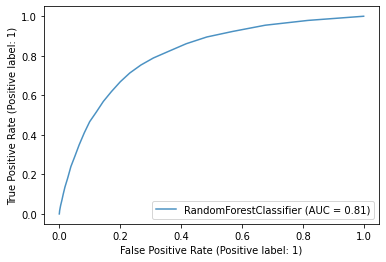

In [93]:
rfc = RandomForestClassifier(n_estimators=30, random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp2 = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [78]:
kaggle_test = test_df[high_float_correlations].fillna(0)

In [79]:
predictions = rfc.predict_proba(kaggle_test)

In [82]:
import numpy as np

(array([3646., 1905., 1290., 1013.,  596.,  764.,  599.,  295.,  108.,
          18.]),
 array([0.        , 0.09333333, 0.18666667, 0.28      , 0.37333333,
        0.46666667, 0.56      , 0.65333333, 0.74666667, 0.84      ,
        0.93333333]),
 <BarContainer object of 10 artists>)

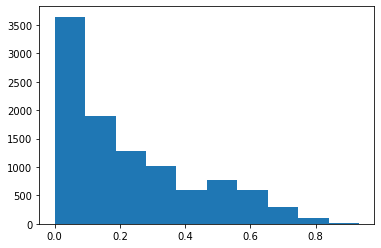

In [91]:
plt.hist(predictions[::,1])
plt.title

(array([9209., 4827., 3249., 2587., 2171., 1862., 1298.,  625.,  193.,
          11.]),
 array([0.        , 0.09666667, 0.19333333, 0.29      , 0.38666667,
        0.48333333, 0.58      , 0.67666667, 0.77333333, 0.87      ,
        0.96666667]),
 <BarContainer object of 10 artists>)

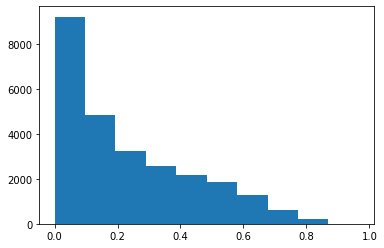

In [90]:
predictions_train = rfc.predict_proba(X_test)
plt.hist(predictions_train[::,1])

In [94]:
rfc.classes_

array([0, 1])